In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import shapiro, normaltest
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# for ensemble method use
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


#TO DO-
#One-R
# sampling SOMTE


# height removed
Test_Target = ["SUSPECT_ARRESTED_FLAG", "STOP_WAS_INITIATED",
                 "OBSERVED_DURATION_MINUTES", "SUSPECTED_CRIME_DESCRIPTION",
                 "STOP_DURATION_MINUTES", "FIREARM_FLAG",
                 "SUSPECT_RACE_DESCRIPTION",
                 "DEMEANOR_OF_PERSON_STOPPED", "SUSPECT_BODY_BUILD_TYPE","FRISKED_FLAG","SEARCHED_FLAG","STOP_LOCATION_BORO_NAME"]
Test1 = pd.read_excel("sqf2022.xlsx", usecols=Test_Target)


In [18]:
Test1["DEMEANOR_OF_PERSON_STOPPED"].isnull().sum()
# check if null value are labeled as arrested or not
# if corealated with any other feature

1907

In [19]:
Test1["DEMEANOR_OF_PERSON_STOPPED"] = Test1["DEMEANOR_OF_PERSON_STOPPED"].fillna(value='neutral')
print(len(Test1["DEMEANOR_OF_PERSON_STOPPED"]))
#Test1['DEMEANOR_OF_PERSON_STOPPED'].applymap(lambda x: x.lower())


15102


In [20]:
analyzer = SentimentIntensityAnalyzer()
dataa = Test1['DEMEANOR_OF_PERSON_STOPPED'].tolist()
data = [ analyzer.polarity_scores(element)['compound'] for element in dataa]

In [21]:
new=[]
for pair in data:
    new.append(pair)
    
#append the 'new' list back to original df
Test1['SENTIMENT_SCORE'] = new

In [22]:
Test1['SENTIMENT_SCORE'].head()

0    0.0000
1    0.0000
2   -0.2732
3    0.3182
4    0.3182
Name: SENTIMENT_SCORE, dtype: float64

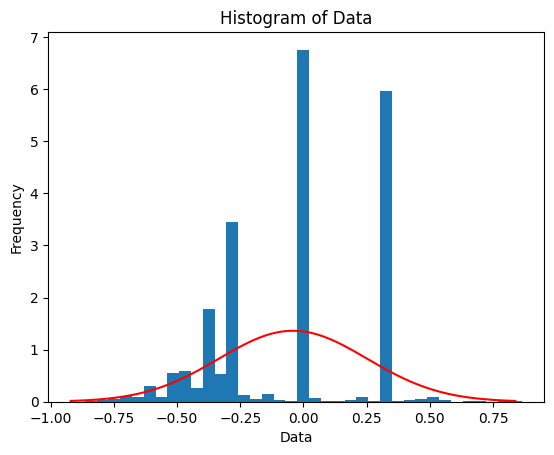

In [23]:
# HISTOGRAM BEFORE SCALING
plt.hist(Test1['SENTIMENT_SCORE'], bins='auto', density=True)

# Plot a normal distribution curve
mu, sigma = np.mean(Test1['SENTIMENT_SCORE']), np.std(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r')

# Display the plot
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

In [48]:
print((Test1['DEMEANOR_OF_PERSON_STOPPED'].tail()))

15097                  neutral
15098                     CALM
15099                COMPLIANT
15100                  ANNOYED
15101    ANNOYED NON COMPLIANT
Name: DEMEANOR_OF_PERSON_STOPPED, dtype: object


In [25]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the column
Test1['SENTIMENT_SCORE'] = scaler.fit_transform(Test1[['SENTIMENT_SCORE']])

In [26]:
Feature_test=["FIREARM_FLAG","FRISKED_FLAG","SEARCHED_FLAG"]

Test1['FIREARM_FLAG'] = Test1['FIREARM_FLAG'].replace('(null)', 'No')
Test1.replace('(null)', np.nan, inplace=True)

lb = LabelBinarizer()
Test1["SUSPECT_ARRESTED_FLAG"] = lb.fit_transform(Test1["SUSPECT_ARRESTED_FLAG"])
Test1["FIREARM_FLAG"] = lb.fit_transform(Test1["FIREARM_FLAG"])
Test1["FRISKED_FLAG"] = lb.fit_transform(Test1["FRISKED_FLAG"])
Test1["SEARCHED_FLAG"] = lb.fit_transform(Test1["SEARCHED_FLAG"])


Test1["SUSPECT_ARRESTED_FLAG"].fillna(Test1["SUSPECT_ARRESTED_FLAG"].median,inplace=True)
Test1["FIREARM_FLAG"].fillna(Test1["FIREARM_FLAG"].median,inplace=True)
Test1["FRISKED_FLAG"].fillna(Test1["FRISKED_FLAG"].median,inplace=True)
Test1["SEARCHED_FLAG"].fillna(Test1["SEARCHED_FLAG"].median,inplace=True)

In [ ]:
print((Test1['DEMEANOR_OF_PERSON_STOPPED'].tail()))

In [27]:
#One Hot-Encoding
OneHot_Encode_feature = ["STOP_WAS_INITIATED","SUSPECTED_CRIME_DESCRIPTION"]
Label_En = OneHotEncoder(handle_unknown="ignore")
Feature_Encoded = Label_En.fit_transform(Test1[OneHot_Encode_feature])
Label_df = pd.DataFrame(Feature_Encoded.toarray(), columns=Label_En.get_feature_names_out(OneHot_Encode_feature))


In [28]:
#label encoding
LE=LabelEncoder()
Test1['SUSPECT_BODY_BUILD_TYPE']=LE.fit_transform(Test1["SUSPECT_BODY_BUILD_TYPE"])
Test1['SUSPECT_BODY_BUILD_TYPE'].fillna(Test1['SUSPECT_BODY_BUILD_TYPE'].mean, inplace=True)

In [29]:
cat_feature=list(Label_df.columns)+Feature_test
Test1 = pd.concat([Test1, Label_df], axis=1)
# drop the original categorical feature column
Test1 = Test1.drop(columns=OneHot_Encode_feature)



# train test split
train_data,test_data=train_test_split(Test1,test_size=0.2,random_state=42)


#classi
X_train = train_data[cat_feature] # training features_for Random forest
y_train = train_data['SUSPECT_ARRESTED_FLAG'] # training target variable for random forest

X_test = test_data[cat_feature] # testing features
y_test = test_data['SUSPECT_ARRESTED_FLAG'] # testing target variable


smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [30]:
# Shapiro-Wilk test
_, shapiro_pvalue = shapiro(Test1['SENTIMENT_SCORE'])
is_normal_sw = shapiro_pvalue > 0.05

# D'Agostino's K^2 test
_, dagostino_pvalue = normaltest(Test1['SENTIMENT_SCORE'])
is_normal_dg = dagostino_pvalue > 0.05

print("Shapiro-Wilk p-value:", shapiro_pvalue)
print("D'Agostino's K^2 p-value:", dagostino_pvalue)
print("Is the data normally distributed (Shapiro-Wilk):", is_normal_sw)
print("Is the data normally distributed (D'Agostino's K^2):", is_normal_dg)


Shapiro-Wilk p-value: 0.0
D'Agostino's K^2 p-value: 0.0
Is the data normally distributed (Shapiro-Wilk): False
Is the data normally distributed (D'Agostino's K^2): False


/Users/iris/Library/Python/3.9/lib/python/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


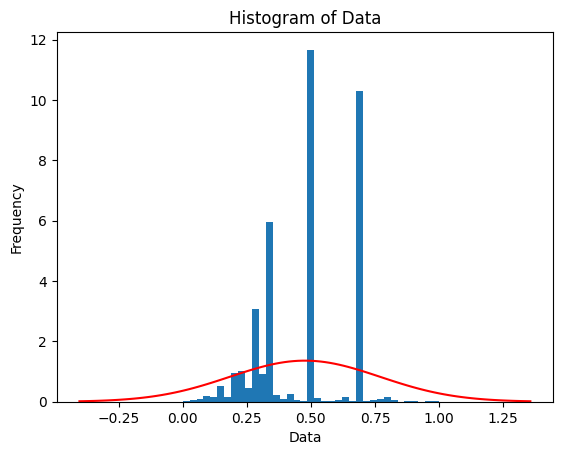

In [31]:
# Create a histogram
plt.hist(Test1['SENTIMENT_SCORE'], bins='auto', density=True)

# Plot a normal distribution curve
mu, sigma = np.mean(Test1['SENTIMENT_SCORE']), np.std(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r')

# Display the plot
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()


In [32]:
Test1['SENTIMENT_SCORE'].head(10)

0    0.500637
1    0.500637
2    0.342462
3    0.684866
4    0.684866
5    0.279585
6    0.500637
7    0.684866
8    0.500637
9    0.684866
Name: SENTIMENT_SCORE, dtype: float64

In [33]:
# naive bayesian model

Model_N=MultinomialNB()
Model_N.fit(X_train,y_train)
N_prediction=Model_N.predict(X_test)
train_N_prediction=Model_N.predict(X_train)
N_train_accuracy=accuracy_score(y_train,train_N_prediction)
N_accuracy=accuracy_score(y_test,N_prediction)

print('Train_Accuracy:', round(N_accuracy*100,4))
print('Accuracy:', round(N_train_accuracy*100,4))
print(confusion_matrix(y_test, N_prediction))

Train_Accuracy: 83.9126
Accuracy: 83.7017
[[1858  186]
 [ 300  677]]


In [34]:
# naive bayesian with oversample

Model_N_Over = MultinomialNB()
Model_N_Over.fit(X_train_oversampled, y_train_oversampled)
N_prediction_Over = Model_N_Over.predict(X_test)
train_N_prediction_Over = Model_N_Over.predict(X_train_oversampled)
N_train_accuracy_Over = accuracy_score(y_train_oversampled, train_N_prediction_Over)
N_accuracy_Over = accuracy_score(y_test, N_prediction_Over)

print('Train_Accuracy:', round(N_train_accuracy_Over*100,4))
print('Accuracy:', round(N_accuracy_Over*100,4))
print(confusion_matrix(y_test, N_prediction_Over))

Train_Accuracy: 79.7287
Accuracy: 79.7418
[[1579  465]
 [ 147  830]]


In [35]:
model_R = RandomForestClassifier(random_state=42)
#model_R.fit(train_data[Feature_test], train_data["SUSPECT_ARRESTED_FLAG"])

#with only caterogical data but transform to numeric/ with both

model_R.fit(X_train,y_train)
Prediction=model_R.predict(X_test)

train_Prediction =model_R.predict(X_train)


train_accuracy=accuracy_score(y_train,train_Prediction)

accuracy = accuracy_score(y_test, Prediction)


print('Train_Accuracy:', round(train_accuracy*100,4))
print('Accuracy:', round(accuracy*100,4))
print(confusion_matrix(y_test, Prediction))

Train_Accuracy: 86.7395
Accuracy: 86.7925
[[1877  167]
 [ 232  745]]


Train_Accuracy: 84.0827
Accuracy: 85.7994


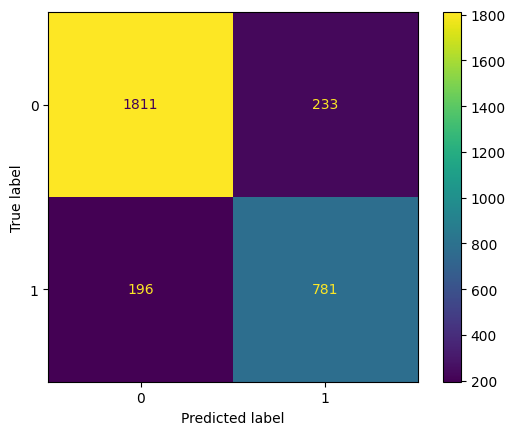

In [36]:
# random classifier with oversampled data

model_R_Over = RandomForestClassifier(random_state=42)
#model_R.fit(train_data[Feature_test], train_data["SUSPECT_ARRESTED_FLAG"])

#with only caterogical data but transform to numeric/ with both
model_R_Over.fit(X_train_oversampled,y_train_oversampled)
Prediction_Over=model_R_Over.predict(X_test)

train_Prediction_Over =model_R_Over.predict(X_train_oversampled)


train_accuracy_Over=accuracy_score(y_train_oversampled,train_Prediction_Over)

accuracy_Over = accuracy_score(y_test, Prediction_Over)


print('Train_Accuracy:', round(train_accuracy_Over*100,4))
print('Accuracy:', round(accuracy_Over*100,4))
rf_over = confusion_matrix(y_test, Prediction_Over)
ConfusionMatrixDisplay(confusion_matrix=rf_over, display_labels=model_R_Over.classes_).plot()
plt.show()

In [37]:
# linear regression 
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the testing and training data, and calculate RMSE
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

print('Testing RMSE:', test_rmse)
print('Training RMSE:', train_rmse)

Testing RMSE: 0.34074823315784813
Training RMSE: 0.34556613691542354


In [38]:
logreg = LogisticRegression(max_iter=1000,random_state=42)
logreg.fit(X_train, y_train)
log_predict=logreg.predict(X_test)
log_score=accuracy_score(y_test,log_predict)

train_log_predict=logreg.predict(X_train)
train_log_score=accuracy_score(y_train,train_log_predict)

print("Accuracy:", round(log_score*100,4))
print("Train Accuract:", round(train_log_score*100,4))

Accuracy: 86.5938
Train Accuract: 86.1104


In [39]:
# logistic regression with over sampling

logreg_Over = LogisticRegression(max_iter=1000, random_state=42)
logreg_Over.fit(X_train_oversampled, y_train_oversampled)
log_predict_Over = logreg_Over.predict(X_test)
log_score_Over = accuracy_score(y_test, log_predict_Over)

train_log_predict_Over = logreg_Over.predict(X_train_oversampled)
train_log_score_Over = accuracy_score(y_train_oversampled, train_log_predict_Over)

print("Accuracy:", round(log_score_Over*100,4))
print("Train Accuracy:", round(train_log_score_Over*100,4))

Accuracy: 86.4283
Train Accuracy: 83.6678


Decision Tree score: 86.5276
Train_Decision Tree score:  86.7395


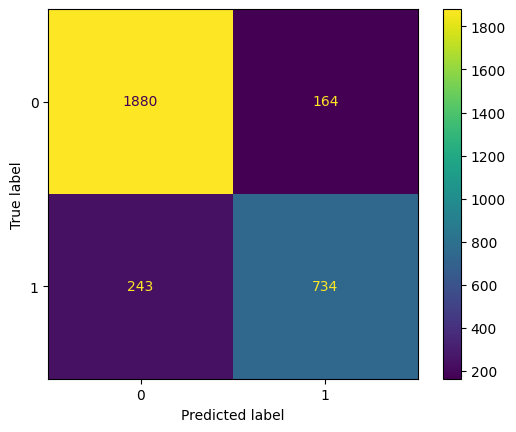

In [40]:
# decision tree

Dec_model=DecisionTreeClassifier(random_state=42)
Dec_model.fit(X_train,y_train)
Dec_predict=Dec_model.predict(X_test)
Train_Dec_predict=Dec_model.predict(X_train)
Dec_accuracy=accuracy_score(y_test,Dec_predict)
Train_Dec_accuracy=accuracy_score(y_train,Train_Dec_predict)
print("Decision Tree score:",round(Dec_accuracy*100,4))
print("Train_Decision Tree score: ",round(Train_Dec_accuracy*100,4))
dt = confusion_matrix(y_test, Dec_predict)
ConfusionMatrixDisplay(confusion_matrix=dt, display_labels=Dec_model.classes_).plot()
plt.show()


In [41]:
#decision tree with over sampling
# RAN ON ERROR
Dec_model_Over=DecisionTreeClassifier(random_state=42)
Dec_model_Over.fit(X_train_oversampled,y_train_oversampled)

Dec_predict_Over=Dec_model_Over.predict(X_test)
Train_Dec_predict_Over=Dec_model_Over.predict(X_train_oversampled)

Dec_accuracy_Over=accuracy_score(y_test, Dec_predict_Over)
Train_Dec_accuracy_Over=accuracy_score(y_train_oversampled,Train_Dec_predict_Over)

print("Decision Tree score:", round(Dec_accuracy_Over*100,4))
print("Train_Decision Tree score: ",round(Train_Dec_accuracy_Over*100,4))


Decision Tree score: 85.8656
Train_Decision Tree score:  84.0827


In [42]:
dummy_class = DummyClassifier(strategy="most_frequent")
dummy_class.fit(X_train,y_train)
y_predict=dummy_class.predict(X_test)
y_train_predict=dummy_class.predict(X_train)
Dummy_accuracy = accuracy_score(y_test, y_predict)
Dummy_train_accuracy = accuracy_score(y_train, y_train_predict)
print("Training Error", round(Dummy_accuracy*100,4))
print("Test Error:", round(Dummy_train_accuracy*100,4))
print(confusion_matrix(y_test, y_predict))

Training Error 67.6597
Test Error: 66.8239
[[2044    0]
 [ 977    0]]


In [43]:
Dec_model_OneR=DecisionTreeClassifier(random_state=42,max_depth=1)
Dec_model_OneR.fit(train_data["SEARCHED_FLAG"].values.reshape(-1, 1), train_data["SUSPECT_ARRESTED_FLAG"])
predictions = Dec_model_OneR.predict(test_data["SEARCHED_FLAG"].values.reshape(-1, 1))
accuracy_OneR = accuracy_score(test_data["SUSPECT_ARRESTED_FLAG"], predictions)
print("Accuracy:", round(accuracy_OneR*100, 4))

Accuracy: 78.7157


In [44]:
estimators=[("logreg", logreg), ("rf", model_R), ("Dc", Dec_model),("Naive",Model_N)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, y_train)
#test our model on the test data
print("Voting Classifier:", round((ensemble.score(X_test, y_test))*100,4))

Voting Classifier: 86.8256


TEST Gradient: 87.0242
Train Gradient: 86.5988


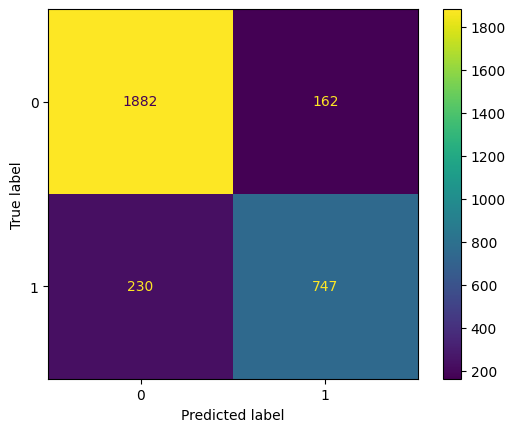

In [45]:
G_Model=GradientBoostingClassifier(random_state=42) #look for the base alg !! Gradient Boosted Decision Trees?
G_Model.fit(X_train,y_train)
G_predict=G_Model.predict(X_test)
G_predict_train=G_Model.predict(X_train)

G_accracy=accuracy_score(y_test,G_predict)
G_accracy_train=accuracy_score(y_train,G_predict_train)
print("TEST Gradient:", round(G_accracy*100, 4))
print("Train Gradient:", round(G_accracy_train*100,4))
gbc = confusion_matrix(y_test, G_predict)
ConfusionMatrixDisplay(confusion_matrix=gbc, display_labels=G_Model.classes_).plot()
plt.show()

In [46]:
models = [RandomForestClassifier(random_state=42),RandomForestClassifier(random_state=42),
            LogisticRegression(random_state=0,max_iter=1000),DecisionTreeClassifier(random_state=42),MultinomialNB(), 
            GradientBoostingClassifier(random_state=42)
         ]
for model in models:
    print(model)
    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10).mean()
    print('C-V Accuracy:', round(score*100, 5), '\n')

RandomForestClassifier(random_state=42)
C-V Accuracy: 86.19324 

RandomForestClassifier(random_state=42)
C-V Accuracy: 86.19324 

LogisticRegression(max_iter=1000, random_state=0)
C-V Accuracy: 86.10216 

DecisionTreeClassifier(random_state=42)
C-V Accuracy: 86.11874 

MultinomialNB()
C-V Accuracy: 83.54441 

GradientBoostingClassifier(random_state=42)
C-V Accuracy: 86.40017 

